This lab activity is intended to teach students the mechanics of the Hartree-Fock procedure, without getting into the details of calculating the 1 and 2 electron integrals, by using the machinary of the Psi4 quantum chemistry software package.

Prerequisite knowledge:  This lab assumes that the students understand the principles, though not the mathematics, of constructing the Fock matrix and that diagaonlizing the Fock matrix leads to the molecular orbital energies and coefficients.  The lab also assumes all the [standard python pre-requisites of all Psi4Education labs](https://admiring-tesla-08529a.netlify.com/posts/psi4jupyter_labs/).  

Learning ojbectives:
1. Recognize that the AO basis is not orthonormal and must be transformed.
2. Transform a from one basis to another using a transformation matrix.
3. Recognize the interative nature of the HF procedure and what leds to the need for the iterative process.  
4. Define convergence and use convergence criteria in a self-consistent procedure. 
5. Calculate MO energies and coefficients by diagonalizing the Fock matrix.  

Authors: Ashley Ringer McDonald (armcdona@calpoly.edu; [ORCID: 0000-0002-4381-1239](https://orcid.org/0000-0002-4381-1239)) and Dominic A. Sirianni (sirianni.dom@gmail.com; [ORCID: 0000-0002-6464-0213](https://orcid.org/0000-0002-6464-0213) )

Copyright: Psi4Education Project, 2019


# Introduction: Hartree-Fock Procedure for Approximate Quantum Chemistry

In [2]:
# ==> Import Psi4 & NumPy packages <==
import os
import sys

sys.path.insert(0,"/usr/local/psi4/lib")

import psi4
import numpy as np

By solving the Hydrogen atom Shr$\ddot{\rm o}$dinger equation, we saw that the expression for the different
energy levels is given by:

$$E_{n} = \frac{m_e e^4}{8\epsilon_0^2h^2n^2}$$

By looking up the values of these constants, we can compute the ground state energy of the Hydrogen atom
numerically. In the cell below, define variables for each of the above constants and compute the exact H atom
ground state energy:

In [3]:
# ==> Toy Example: The Hydrogen Atom <==
# Define fundamental constants in SI units
# not quite sure where to obtain these values
m_e = 9.1093837015e-31 # kg
e = 1.602176634e-19 # C
epsilon_0 = 8.8541878128e-12 # F / m
h = 6.62607015e-34 # J*s
n = 1

# Define a.u. to SI energy conversion factor
# https://www.convertunits.com/from/hartree/to/joule
hartree2joules = 4.3597482e-18

def energy(m_e, e, epsilon_0, h, n):
    return (m_e * e**4) / (8 * epsilon_0**2 * h**2 * n**2)

# Compute ground state energy of H atom in SI units
E_1 = energy(m_e, e, epsilon_0, h, n)

# Convert SI energy to atomic units
E_1_au = E_1 / hartree2joules

print(f'The exact ground state energy in SI units is: {E_1}')
print(f'The exact ground state energy in atomic units is: {E_1_au}')

The exact ground state energy in SI units is: 2.1798723610862185e-18
The exact ground state energy in atomic units is: 0.49999960114352904


We obtained the Hydrogen atom energy expression above by solving the Schr$\ddot{\rm o}$dinger equation exactly.
But what happens if we cannot do this?

That's where Hartree-Fock molecular orbital theory comes in! Just as a test case, let's use Psi4 to compute the
Hartree-Fock wavefunction and energy for the Hydrogen atom:

In [4]:
# ==> Compute H atom energy with Hartree-Fock using Psi4 <==
h_atom = psi4.geometry("""
0 2
H 0 0 0
""")

psi4.set_options({'reference': 'rohf',
                  'scf_type': 'pk'
                 })

e = psi4.energy('scf/d-aug-cc-pv5z')

print(f"The H atom energy in Eh: {e} Eh")
print(f"The H atom energy in J: {e * psi4.constants.hartree2J} J")

The H atom energy in Eh: -0.4999948009253332 Eh
The H atom energy in J: -2.1798496583620362e-18 J


## The Hartree-Fock procedure
In this lab activity, you will be building and diagonalizing the Fock matrix to determine the MO coefficients and energies for a molecule.  We will be using the functions of the Psi4 quantum chemistry software package to compute the integrals we need.  The following notebook will lead you through setting up your molecule, establishing the basis set, and forming and diagonalizing the Fock matrix.  Be sure to run each cell as your proceed through the notebook.

### Specifying the molecule
Before we can begin to implement the HF procedure, we need to specifcy the molecule and basis set that we will be using.  We will also set the memory usage for our calcluation and the output file name.  

In [5]:
# ==> Set Basic Psi4 Options <==
# Memory specification
psi4.set_memory('500 MB')
numpy_memory = 2 # No NumPy aray can exceed 2 MB in size

# Set output file
psi4.core.set_output_file('output.dat', False)

# Define Physicist's water -- don't forget C1 symmetry!
mol = psi4.geometry("""
O
H 1 1.1
H 1 1.1 2 104
symmetry c1
""")

# Set computation options
psi4.set_options({'basis': 'cc-pvdz',
                  'scf_type': 'pk',
                  'e_convergence': 1e-8})

The Hartree Fock procedure is iterative (more on this later).  We continue recalculating the energy until it converges to the level we specify.  The varible `E_conv` is where we set this level of convergence.  We also set a maximum number of iterations so that if our calculation does not converge, it eventually stops and lets us know that it did not converge.  

In [6]:
# ==> Set default program options <==
# Maximum SCF iterations
MAXITER = 40
# Energy convergence criterion
E_conv = 1.0e-6

Next, we need to build the wavefunction from the basis functions.  We store the wavefunction in a variable called `wfn`.  Next we have to set up a data structure, called a class, to calculate the molecular integrals.  We will call this data structure `mints`.

In [7]:
# ==> Compute static 1e- and 2e- quantities with Psi4 <==
wfn = psi4.core.Wavefunction.build(mol, psi4.core.get_global_option('basis'))
mints = psi4.core.MintsHelper(wfn.basisset())

We use the function `ao_overlap` to calculate the overlap integrals between all the AO basis functions.  We cast this to a numpy array called `S`. 

In [8]:
# Overlap matrix
S = np.asarray(mints.ao_overlap())

In [9]:
# overlap integrals between all the AO basis functions

# Docstring for .ao_overlap()
# 1. ao_overlap(self: psi4.core.MintsHelper) -> psi4.core.Matrix
# AO basis overlap integrals

# 2. ao_overlap(self: psi4.core.MintsHelper, arg0: psi::BasisSet, arg1: psi::BasisSet) -> psi4.core.Matrix
# AO mixed basis overlap integrals

S

array([[ 1.00000000e+00, -2.14062652e-01,  1.94384152e-01,
         6.12784785e-18,  0.00000000e+00,  0.00000000e+00,
        -2.40224100e-18,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.81372730e-18,  0.00000000e+00,  3.45999929e-02,
         6.15289762e-02, -3.97443884e-02,  0.00000000e+00,
         5.08704974e-02,  3.45999929e-02,  6.15289762e-02,
        -3.97443884e-02,  0.00000000e+00, -5.08704974e-02],
       [-2.14062652e-01,  1.00000000e+00,  7.08607329e-01,
         5.75156168e-17,  0.00000000e+00,  0.00000000e+00,
         1.51143471e-17,  0.00000000e+00,  0.00000000e+00,
        -1.11022302e-16,  0.00000000e+00,  0.00000000e+00,
        -1.19983924e-18,  0.00000000e+00,  1.96930552e-01,
         2.90859084e-01, -1.91271784e-01,  0.00000000e+00,
         2.44816719e-01,  1.96930552e-01,  2.90859084e-01,
        -1.91271784e-01,  0.00000000e+00, -2.44816719e-01],
       [ 1.94384152e-01,  7.08607329e-01,  1.00000000e

Now that we have constructed a matrix of the overlap integrals, we can determine how many basis functions we have and how many occupied orbitals there are.  Since we know how many electrons our molecule has, this can be a good check to make sure our code is working correctly so far.   In the box below, use the function `nalpha()` acting on the wavefunction object we created above to determine the number of doubly occupied orbitals.  Save this answer as a variable called `ndocc`.  This should match your expectation for the molecule you chose.

Then determine the number of basis functions.  Remember that your overlap matrix is of size NxN where N is the number of basis functions.  Use the numpy documentation to look up the `shape` function and use that function to determine the size of the `S` array.  Use that information to determine how many basis functions there are and save your answer in a variable called `nbf`.

In [12]:
# so this gets the number of "doubly occupied orbitals" (not num of electrons)
# so ndocc times 2 should be 10 cuz water has 10 electrons
ndocc = wfn.nalpha()
# size_overlap = unsure what this is as there is no info above

nbf = S.shape[0]

print(F'Number of occupied orbitals: {ndocc}')
print(F'Number of basis functions: {nbf}') 

Number of occupied orbitals: 5
Number of basis functions: 24


Now that our basis set checks out, we can build the electron-repulsion integral tensor, which calculates the electron repulsion between the atomic orbital wavefunctions, and the core Hamiltonian.

In [13]:
# Build ERI Tensor
I = np.asarray(mints.ao_eri())

# Build core Hamiltonian
T = np.asarray(mints.ao_kinetic())
V = np.asarray(mints.ao_potential())
H = T + V

In [14]:
H

array([[-3.28832658e+01,  7.83815073e+00, -5.90156618e+00,
        -2.33515260e-02,  0.00000000e+00,  0.00000000e+00,
        -4.40199641e-03,  0.00000000e+00,  0.00000000e+00,
        -2.81441998e-04,  0.00000000e+00,  1.87789325e-19,
         2.20760832e-03,  0.00000000e+00, -1.03024333e+00,
        -1.84837357e+00,  1.19286409e+00,  0.00000000e+00,
        -1.52768144e+00, -1.03024333e+00, -1.84837357e+00,
         1.19286409e+00,  0.00000000e+00,  1.52768144e+00],
       [ 7.83815073e+00, -1.01354994e+01, -4.94532741e+00,
        -1.30232174e-01,  0.00000000e+00,  0.00000000e+00,
        -9.08299843e-02,  0.00000000e+00,  0.00000000e+00,
        -6.90722590e-03,  0.00000000e+00,  1.20185168e-17,
         5.41797226e-02,  0.00000000e+00, -1.51898530e+00,
        -2.14678487e+00,  1.39650863e+00,  0.00000000e+00,
        -1.80601604e+00, -1.51898530e+00, -2.14678487e+00,
         1.39650863e+00,  0.00000000e+00,  1.80601604e+00],
       [-5.90156618e+00, -4.94532741e+00, -7.50633074e

Recall that if we had used the hydrogen atom wavefunctions as our basis set, the AO wavefunctions would all be orthonormal.  Since we used a real basis set of Gaussian wavefuctions, this may not be the case.  We need to check our the overlap integral array and see if we have an orthonormal basis.

Question:  If our basis was orthonormal, what would the overlap integral array look like?

#### Student Answer Box

Ok ok, so orthonormal means orthogonal and unit vectors. So a bunch of 1's in the matrix where they're all orthogonal. (identity matrix)




Construct an array of the same size as the overlap array (`S`) that has 1's along the diagonal and 0's everywhere else.  Use the numpy documentation to identify a function to do this.  Then compare that array to the `S` array to determine if the AO basis is orthonormal.

In [17]:
# so an identity matrix..?
size_S = S.shape[0]
comparison_array = np.eye(size_S)


# hmm need more here, obviously by looking at H its very different from identity
orthonormal_check = False

print(f'The AO basis is orthonormal? {orthonormal_check}')

The AO basis is orthonormal? False


Since our AO basis set was not orthonormal, we must construct an orthogonalization matrix, `A` such that ${\bf A}^{\dagger}{\bf SA} = {\bf 1}$, and cast it to a numpy array.

In [18]:
# ==> Construct AO orthogonalization matrix A <==
A = mints.ao_overlap()
A.power(-0.5, 1.e-16)
A = np.asarray(A)

Use the orthogonalization matrix `A` to transform the overlap matrix, `S`. Check the transformed overlap matrix to make sure it represents an orthonormal basis.

In [19]:
# This is the code we would expect the student to write
# so do the dot prods
S_p = A.dot(S).dot(A)

# peeked here at the instructor nb, allclose grrr
transformation_check = np.allclose(S_p, comparison_array)
# Returns True if two arrays are element-wise equal within a tolerance.

if transformation_check is True:
    print('Transformation success!')
else:
    print("Whoops...something went wrong. Check that you've correctly built the transformation matrix.")

Transformation success!


Now we would have to recompute the ERI and all the core Hamiltonian matrices in the new orthogonal basis **OR** we can just calculate orbital coefficient matrix in the transformed basis by diagonalizing the transformed Fock matrix, and then just go backwards and get the cofficients in the original AO basis.

We see here the central premise of SCF:  To get the Fock matrix, we need the coefficient matrix, but to compute the coefficient matrix we need the Fock matrix.  So we start with a guess for the Fock matrix, which is the core Hamiltonian matrix that we already calculated.

In the cell below, use the core Hamiltonian matrix as your initial guess for the Fock matrix. Transform it with the same A matrix you used above.  Look up the `linalg.eigh` function in the numpy documentation, and use it to diagonalize the transformed Fock matrix.

In [22]:
# This is the code we would expect the student to write

# Transformed Fock matrix
# core hamiltonian is H, orthogonalization matrix is A
F_p = A.dot(H).dot(A)

# Diagonalize F_p for eigenvalues & eigenvectors with NumPy
e, C_p = np.linalg.eigh(F_p)
# Return the eigenvalues and eigenvectors of a 
# complex Hermitian (conjugate symmetric) or a real symmetric matrix.

In [25]:
e

array([-32.91317315,  -8.74494834,  -8.50582561,  -8.40311052,
        -8.39382404,  -4.73371868,  -4.64557803,  -4.34439439,
        -4.2669162 ,  -4.22658219,  -4.17922912,  -4.05767035,
        -3.84153828,  -3.83152535,  -3.03112028,  -3.0246779 ,
        -2.5124168 ,  -2.49262155,  -2.48348811,  -2.3508696 ,
        -2.29853262,  -2.27646853,  -1.51058272,  -1.42134636])

Now that we have the coefficents in the transformed basis, we need to go back and get the coefficients in the original AO basis.

In [27]:
# peeked here, unclear that C = A dot C_p
# Transform C_p back into AO basis
C = A.dot(C_p)

Next, we are going to construct the density matrix from the occupied orbitals.  To get a matrix of just the occupied orbitals, use the coefficient matrix in the original AO basis, and take a slice to include all rows and just the columns that represent the occupied orbitals.

In [40]:
C[0].shape # 24 calcs

(24,)

In [30]:
# only want the 5 occupied orbs

# Grab occupied orbitals
C_occ = C[:, :ndocc]

In [42]:
C_occ[0].shape

(5,)

To build the density matrix, we will use the numpy function `einsum`, one of the crown jewels of the numpy library.  In short, `einsum` lets you perform various combinations of multiplying, summing, and transposing matrices very efficiently.  A good tutorial about `einsum` can be found at http://ajcr.net/Basic-guide-to-einsum/.  To specify the operations you want to do, you use the **Ein**stein **Sum**mation convention.

In [43]:
# Build density matrix from occupied orbitals
D = np.einsum('pi,qi->pq', C_occ, C_occ)

Now we will use the density matrix to build the Fock matrix.  The code block below sets up the skelton of the Hartree-Fock procedure.  The basic steps are:
1. Calculate the Fock Matrix from the density matrix and the nuclear repulsion energy (which we only need to calculate once at the beginning because we are invoking the the Born-Oppenheimer approximation thus making the nucleus stationary.  
2. Calculate the energy from the Fock matrix.
3. Check and see if the energy has converged by comparing the current energy to the previous energy and seeing if it is within the convergence threshold.  (You will write this section.)
4. If the energy has not converged, transform the Fock matrix, and diagonalize the transformed Fock matrix to get the energy and MO coefficients.  Then transform back to the original AO basis, pull the occupied orbitals, and reconstruct the density matrix.  (You will write this section.)

Follow the prompts below to complete your HF code.

In [45]:
# ==> Nuclear Repulsion Energy <==
E_nuc = mol.nuclear_repulsion_energy()

# ==> SCF Iterations <==
# Pre-iteration energy declarations
SCF_E = 0.0
E_old = 0.0

print('==> Starting SCF Iterations <==\n')

# Begin Iterations
for scf_iter in range(1, MAXITER + 1):
    # Build Fock matrix
    J = np.einsum('pqrs,rs->pq', I, D)
    K = np.einsum('prqs,rs->pq', I, D)
    F = H + 2*J - K
    
    # Compute RHF energy; this use of einsum is matrix multiplication
    SCF_E = np.einsum('pq,pq->', (H + F), D) + E_nuc
    print(F'SCF Iteration {scf_iter}: Energy = {SCF_E:.8f} dE = {SCF_E - E_old:.8f}')
    
    # Check to see if the energy is converged.  If it is break out of the loop.
    # If it is not, set the current energy E_old
    
    ## This is the code we would expect the student to write
    
    # Compute new orbital guess.  Remember the steps:
    # 1. Transform the Fock matrix
    F_p = A.dot(F).dot(A)
    # 2. Diagonalize the Fock matrix.
    e, C_p = np.linalg.eigh(F_p)
    # 3. Tranform the coefficient matrix back to original AO basis set
    C = A.dot(C_p)
    # 4. Take a slice of the coefficient matrix of just the occupied orbitals.
    C_occ = C[:, :ndocc]
    # 5. Use the occupied orbitals to construct the density
    D = np.einsum('pi,qi->pq', C_occ, C_occ)
    ## This is the code we would expect the student to write
    
    # MAXITER exceeded?
    if (scf_iter == MAXITER):
        psi4.core.clean()
        raise Exception("Maximum number of SCF iterations exceeded.")

# Post iterations
print('\nSCF converged.')
print(F'Final RHF Energy: {SCF_E:.6f} [Eh]')

==> Starting SCF Iterations <==

SCF Iteration 1: Energy = -68.98003273 dE = -68.98003273
SCF Iteration 2: Energy = -69.64725444 dE = -69.64725444
SCF Iteration 3: Energy = -72.84030311 dE = -72.84030311
SCF Iteration 4: Energy = -72.89488392 dE = -72.89488392
SCF Iteration 5: Energy = -74.12078067 dE = -74.12078067
SCF Iteration 6: Energy = -74.86718198 dE = -74.86718198
SCF Iteration 7: Energy = -75.41490880 dE = -75.41490880
SCF Iteration 8: Energy = -75.70767222 dE = -75.70767222
SCF Iteration 9: Energy = -75.86052422 dE = -75.86052422
SCF Iteration 10: Energy = -75.93143853 dE = -75.93143853
SCF Iteration 11: Energy = -75.96402440 dE = -75.96402440
SCF Iteration 12: Energy = -75.97842921 dE = -75.97842921
SCF Iteration 13: Energy = -75.98481700 dE = -75.98481700
SCF Iteration 14: Energy = -75.98761284 dE = -75.98761284
SCF Iteration 15: Energy = -75.98884089 dE = -75.98884089
SCF Iteration 16: Energy = -75.98937775 dE = -75.98937775
SCF Iteration 17: Energy = -75.98961294 dE = -75

Exception: Maximum number of SCF iterations exceeded.

Compare your results to Psi4 by computing the energy using `psi4.energy()` in the cell below.  

In [47]:
# ==> Compare our SCF to Psi4 <==
# Call psi4.energy() to compute the SCF energy
SCF_E_psi = psi4.energy('HF', molecule=mol)

# Compare our energy value to what Psi4 computes
assert psi4.compare_values(SCF_E_psi, SCF_E, 6, 'My SCF Procedure')

    My SCF Procedure..................................................PASSED


## Using Hartree-Fock to Justify Molecular Structure

Why is CO$_2$ linear? Why is H$_2$O bent? Why is CH$_4$ tetrahedral? Why is FeF$_6$ octahedral? In general
chemistry, we used valence shell electron pair repulsion (VSEPR) theory to justify molecular structures
by invoking a _repulsion_ between both bonding and non-bonding pairs of electrons.  The reality of molecular
structure is more complicated, however.

In this section of the lab, we will use the same Hartree-Fock method that we implemented above to justify the
bent structure of water by computing the electronic energy of H$_2$O at a variety of bond angles.  


In [55]:
# ==> Scanning a Bond Angle: Flexible Water <==
# Import a library to visualize energy profile
import matplotlib.pyplot as plt
%matplotlib inline

# Define flexible water molecule using Z-matrix
flexible_water = """
O
H 1 0.96
H 1 0.96 2 theta
"""

# Scan over bond angle range between 90 & 180, in 5 degree increments
scan = {}
for angle in range(90, 181, 5):
    # Make molecule with particular bond angle
    mol = psi4.geometry(flexible_water.replace('theta', str(angle)))
    # Call psi4.energy(), specify molecule=mol
    e = psi4.energy('HF', molecule=mol)
    # Save energy in dictionary
    scan[angle] = e

In [56]:
scan

{90: -76.02075342467673,
 95: -76.02425116083828,
 100: -76.02617850030151,
 105: -76.02663653742182,
 110: -76.02574146770581,
 115: -76.02362460621903,
 120: -76.02043144800514,
 125: -76.0163210559426,
 130: -76.01146627892723,
 135: -76.00605457281367,
 140: -76.0002887611862,
 145: -75.99438688069651,
 150: -75.98858018703251,
 155: -75.98310842394635,
 160: -75.97821165912117,
 165: -75.9741184881008,
 170: -75.97103125295152,
 175: -75.96910998427596,
 180: -75.96845769690123}

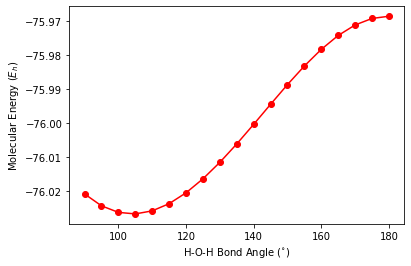

In [65]:
# Visualize energy profile
plt.plot([*scan.keys()], [*scan.values()], 'ro-') # diff versions of python here can confuse students
# scan.keys() returns a dict_keys object not a list, need to unzip it (what the * does)

plt.xlabel('H-O-H Bond Angle ($^{\circ}$)')
plt.ylabel('Molecular Energy ($E_h$)')
plt.show()

In [67]:
# example

d = {1: 'foo', 2: 'bar'}

print(d.keys(), type(d.keys()))
print([*d.keys()], type([*d.keys()]))

dict_keys([1, 2]) <class 'dict_keys'>
[1, 2] <class 'list'>


Using the energy profile we generated above, justify the experimentally measured water bond angle of 104.5$^{\circ}$ in the cell below.

#### Student Answer Box

Ummm idk